In [1]:
#%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import sys
projectDir = "/content/drive/My Drive/code/git/TwitterDeepFakeText"
sys.path.insert(0, projectDir)

random_state = 523 # Fixed seed for replicability of randomic operations.
resultsDir = projectDir+"/data/results"

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
from DataHandler import DataHandler

csvTrainDataset = projectDir+"/data/splits/train.csv"
csvValDataset = projectDir+"/data/splits/validation.csv"
csvTestDataset = projectDir+"/data/splits/test.csv"

bertDir = projectDir+"/data/encoded/bert"
dh = DataHandler()
dfTrain = dh.readCSVData(csvTrainDataset)
dfVal = dh.readCSVData(csvValDataset)
dfTest = dh.readCSVData(csvTestDataset)

In [4]:
available_result_names = ["logistic_regression_bow", "random_forest_bow", "svc_bow",
                          "logistic_regression_bert", "random_forest_bert", "svc_bert",
                          "char_cnn", "char_gru", "char_cnngru",
                          "bert_finetuning", "distillbert_finetuning", "roberta_finetuning", "xlnet_finetuning"]
mapMethodNames = {"logistic_regression_bow":"LOG_REG_BOW",
                  "random_forest_bow": "RAND_FOREST_BOW",
                  "svc_bow": "SVC_BOW",
                  "logistic_regression_bert":"LOG_REG_BERT",
                  "random_forest_bert": "RAND_FOREST_BERT",
                  "svc_bert":"SVC_BERT",
                  "char_cnn": "CHAR_CNN", "char_gru":"CHAR_GRU",
                  "char_cnngru":"CHAR_CNNGRU", "bert_finetuning":"BERT_FT",
                  "distillbert_finetuning": "DISTILBERT_FT", "roberta_finetuning":"ROBERTA_FT",
                  "xlnet_finetuning": "XLNET_FT"}

dfCmp = dfTest[["screen_name","text", "account.type", "class_type"]]
dfCmp.columns = ["screen_name","text", "gold", "class_type"]

for name in available_result_names:
  fname = projectDir+"/data/results/"+name+".csv"
  df = dh.readCSVData(fname, sep="\t")
  dfCmp[mapMethodNames[name]] = df['prediction']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
dfCmp

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
0,zawvrk,justin timberlake really one of the goats if y...,human,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,human,bot,bot,bot
1,narendramodi,Thank you @PMBhutan for your gracious prayers ...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
2,ahadsheriff,Theory: the number of red lights you will hit ...,human,human,bot,bot,bot,human,human,human,bot,bot,bot,bot,human,human,human
3,AINarendraModi,Respects on the Upt of the I good with the peo...,bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
4,kevinhooke,Might give the BASIC #10Liner game contest ano...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,ahadsheriffbot,“The best kept secret,bot,others,bot,bot,bot,bot,bot,bot,bot,human,bot,bot,bot,bot,bot
2554,kevinhooke,Love the Choose your own adventure style of th...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
2555,dril_gpt2,JOIN OUR TEAM: Sneezing,bot,gpt2,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,human
2556,kevinhooke,These deeply discounted 256GB SanDisk flash dr...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human


In [6]:
dictLabels = {"human":0, "bot":1}
targetNames = ["human", "bot"]
dictLabelsReverse = {0:"human", 1: "bot"}

In [7]:
def print_classification_reports(df, dictLabels, available_result_names, targetNames):
  from sklearn.metrics import classification_report
  from sklearn.metrics import f1_score, precision_score, recall_score
  gold = [dictLabels[t] for t in df["gold"].tolist()]
  for oname in available_result_names:
    name = mapMethodNames[oname]
    print("**** RESULTS FOR -> "+name)
    prediction = [dictLabels[t] for t in df[name].tolist()]
    print(classification_report(gold, prediction, target_names=targetNames, digits=3))
    print("Weighted precision: "+str(precision_score(gold, prediction, average='weighted')))
    print("Weighted recall: "+str(recall_score(gold, prediction, average='weighted')))
    print("Weighted F1: "+str(f1_score(gold, prediction, average='weighted')))

print_classification_reports(dfCmp, dictLabels, available_result_names, targetNames)

**** RESULTS FOR -> LOG_REG_BOW
              precision    recall  f1-score   support

       human      0.841     0.749     0.792      1278
         bot      0.774     0.859     0.814      1280

    accuracy                          0.804      2558
   macro avg      0.807     0.804     0.803      2558
weighted avg      0.807     0.804     0.803      2558

Weighted precision: 0.807420153244258
Weighted recall: 0.8037529319781079
Weighted F1: 0.8031548525520171
**** RESULTS FOR -> RAND_FOREST_BOW
              precision    recall  f1-score   support

       human      0.759     0.798     0.778      1278
         bot      0.787     0.747     0.767      1280

    accuracy                          0.772      2558
   macro avg      0.773     0.772     0.772      2558
weighted avg      0.773     0.772     0.772      2558

Weighted precision: 0.7732151505638727
Weighted recall: 0.7724784988272088
Weighted F1: 0.7723315327109778
**** RESULTS FOR -> SVC_BOW
              precision    recall  f1

In [8]:
def plotErrorRatioForExperiment(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "gold", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "gold"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["gold"] == X_verify[prediction_column]]
  #X_verify = X_verify[X_verify["gold"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["gold"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  return X_verify[X_verify["num_samples"] >= min_sample_num][["error_ratio"]]


def plotErrorRatioForExperiment2(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "gold", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "gold"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["gold"] == X_verify[prediction_column]]
  #X_verify = X_verify[X_verify["gold"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["gold"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  return X_verify[X_verify["num_samples"] >= min_sample_num][["error_ratio"]]



def plotErrorRatiosAllExps(df, available_result_names, min_sample_num=30):
  import pandas as pd
  dfTarget = pd.DataFrame()
  for oname in available_result_names:
    name = mapMethodNames[oname]
    tmpDf = plotErrorRatioForExperiment(df, name, min_sample_num=min_sample_num)
    dfTarget[name] = tmpDf["error_ratio"]

  return dfTarget


In [9]:
dfCmp

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
0,zawvrk,justin timberlake really one of the goats if y...,human,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,human,bot,bot,bot
1,narendramodi,Thank you @PMBhutan for your gracious prayers ...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
2,ahadsheriff,Theory: the number of red lights you will hit ...,human,human,bot,bot,bot,human,human,human,bot,bot,bot,bot,human,human,human
3,AINarendraModi,Respects on the Upt of the I good with the peo...,bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
4,kevinhooke,Might give the BASIC #10Liner game contest ano...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,ahadsheriffbot,“The best kept secret,bot,others,bot,bot,bot,bot,bot,bot,bot,human,bot,bot,bot,bot,bot
2554,kevinhooke,Love the Choose your own adventure style of th...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
2555,dril_gpt2,JOIN OUR TEAM: Sneezing,bot,gpt2,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,human
2556,kevinhooke,These deeply discounted 256GB SanDisk flash dr...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human


Text(0, 0.5, 'Accuracy')

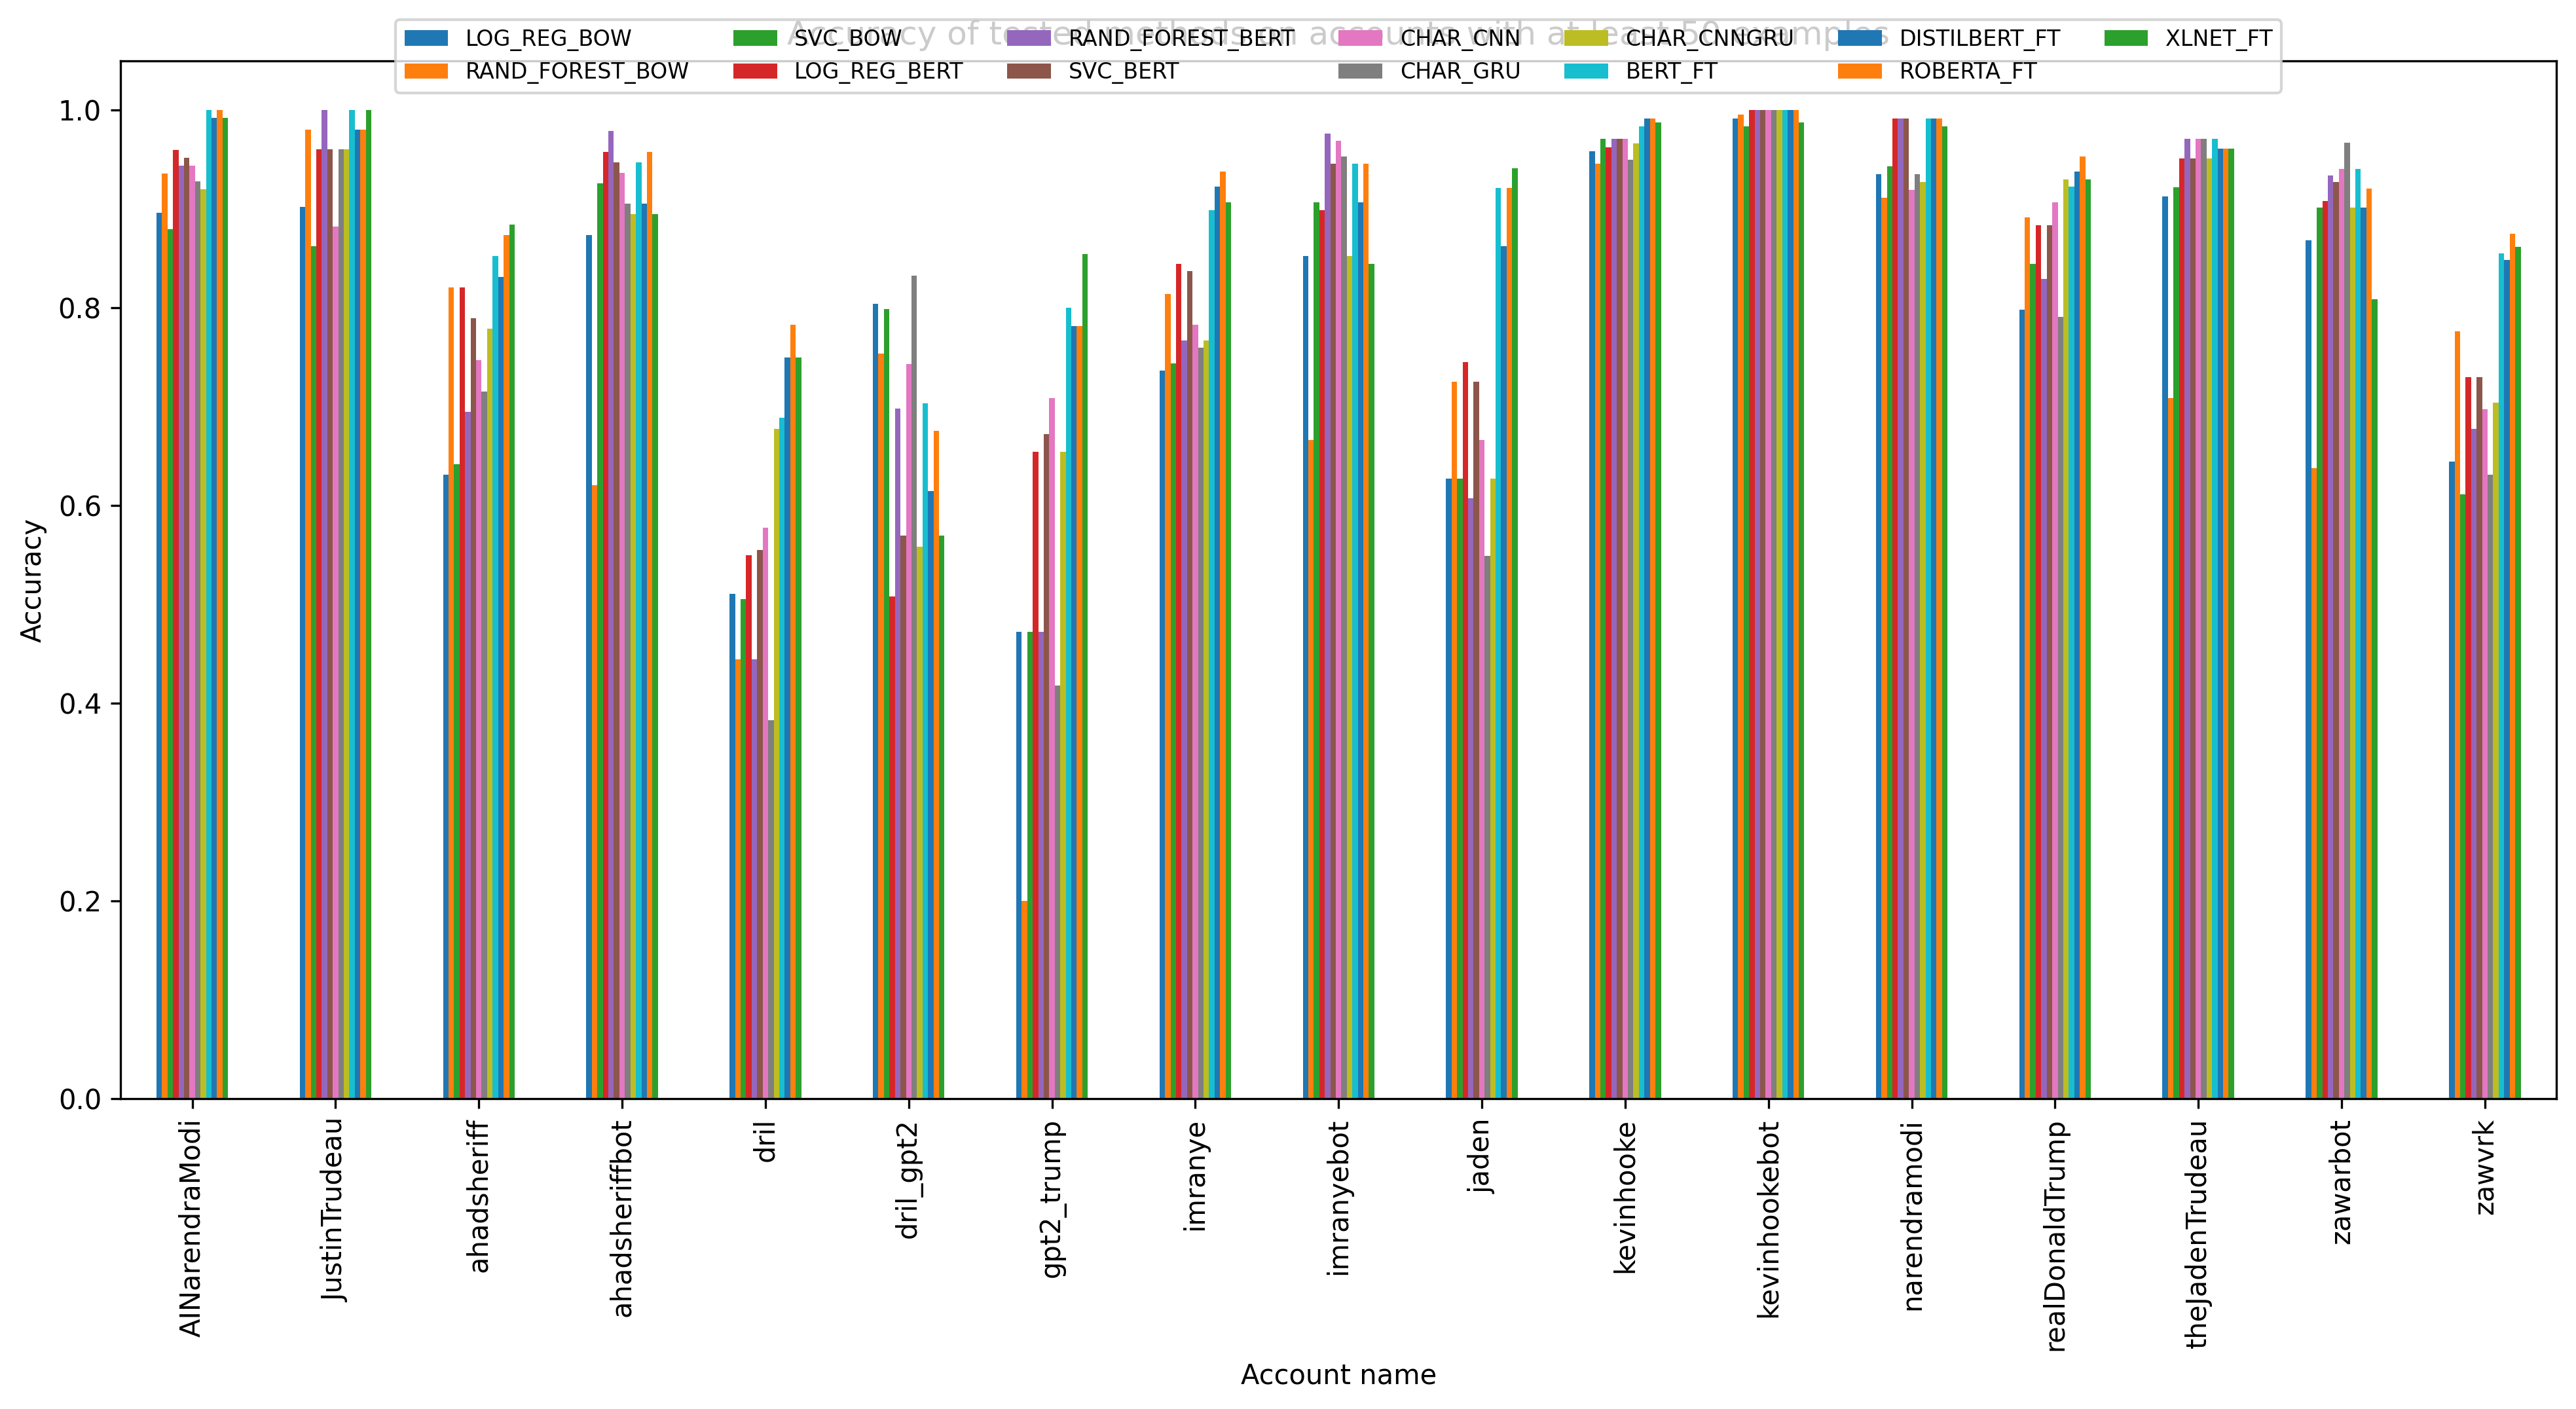

In [10]:
ax = plotErrorRatiosAllExps(dfCmp, available_result_names, 50).fillna(0).plot.bar(figsize=(16,7), title='Accuracy of tested methods on accounts with at least 50 examples')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=7, prop={'size': 8})
ax.set_xlabel("Account name")
ax.set_ylabel("Accuracy")

Getting results for accounts of type "humans"



In [11]:
dfHumans = dfCmp[dfCmp["class_type"] == "human"].sample(n=488, replace=False, random_state=1)
dfHumans

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
260,narendramodi,I heartily congratulate HM Sayyid Haitham bin ...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
1293,realDonaldTrump,Brazil and Argentina have been presiding over ...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
777,realDonaldTrump,Without the horror show that is the Radical Le...,human,human,bot,bot,human,human,bot,bot,human,bot,human,human,human,human,human
488,narendramodi,Parth Sarthi has displayed immense persistence...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
1956,ahadsheriff,@fareenii Imagine driving a 3 series <U+0001F4...,human,human,bot,human,bot,human,bot,human,human,human,human,human,human,human,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,kevinhooke,"@retroist @8BitShowAndTell I spent many, many ...",human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
2202,dril,wiki/Coprophagia/media/File:Adonis_Blue_butter...,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
16,awhalefact,"@thatrebaf i’m sorry my jokes killed you, i wh...",human,human,human,human,human,human,human,human,human,human,human,human,human,human,human
1105,zawvrk,wtffff lmao https://t.co/GlIIX24puS,human,human,human,human,human,human,human,human,human,human,human,human,human,human,human


In [12]:
print_classification_reports(dfHumans, dictLabels, available_result_names, targetNames)

**** RESULTS FOR -> LOG_REG_BOW
              precision    recall  f1-score   support

       human      1.000     0.732     0.845       488
         bot      0.000     0.000     0.000         0

    accuracy                          0.732       488
   macro avg      0.500     0.366     0.422       488
weighted avg      1.000     0.732     0.845       488

Weighted precision: 1.0
Weighted recall: 0.7315573770491803
Weighted F1: 0.8449704142011835
**** RESULTS FOR -> RAND_FOREST_BOW
              precision    recall  f1-score   support

       human      1.000     0.801     0.890       488
         bot      0.000     0.000     0.000         0

    accuracy                          0.801       488
   macro avg      0.500     0.401     0.445       488
weighted avg      1.000     0.801     0.890       488

Weighted precision: 1.0
Weighted recall: 0.8012295081967213
Weighted F1: 0.8896473265073948
**** RESULTS FOR -> SVC_BOW
              precision    recall  f1-score   support

       huma

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, "Accuracy of tested methods on 'human' accounts with at least 10 examples")

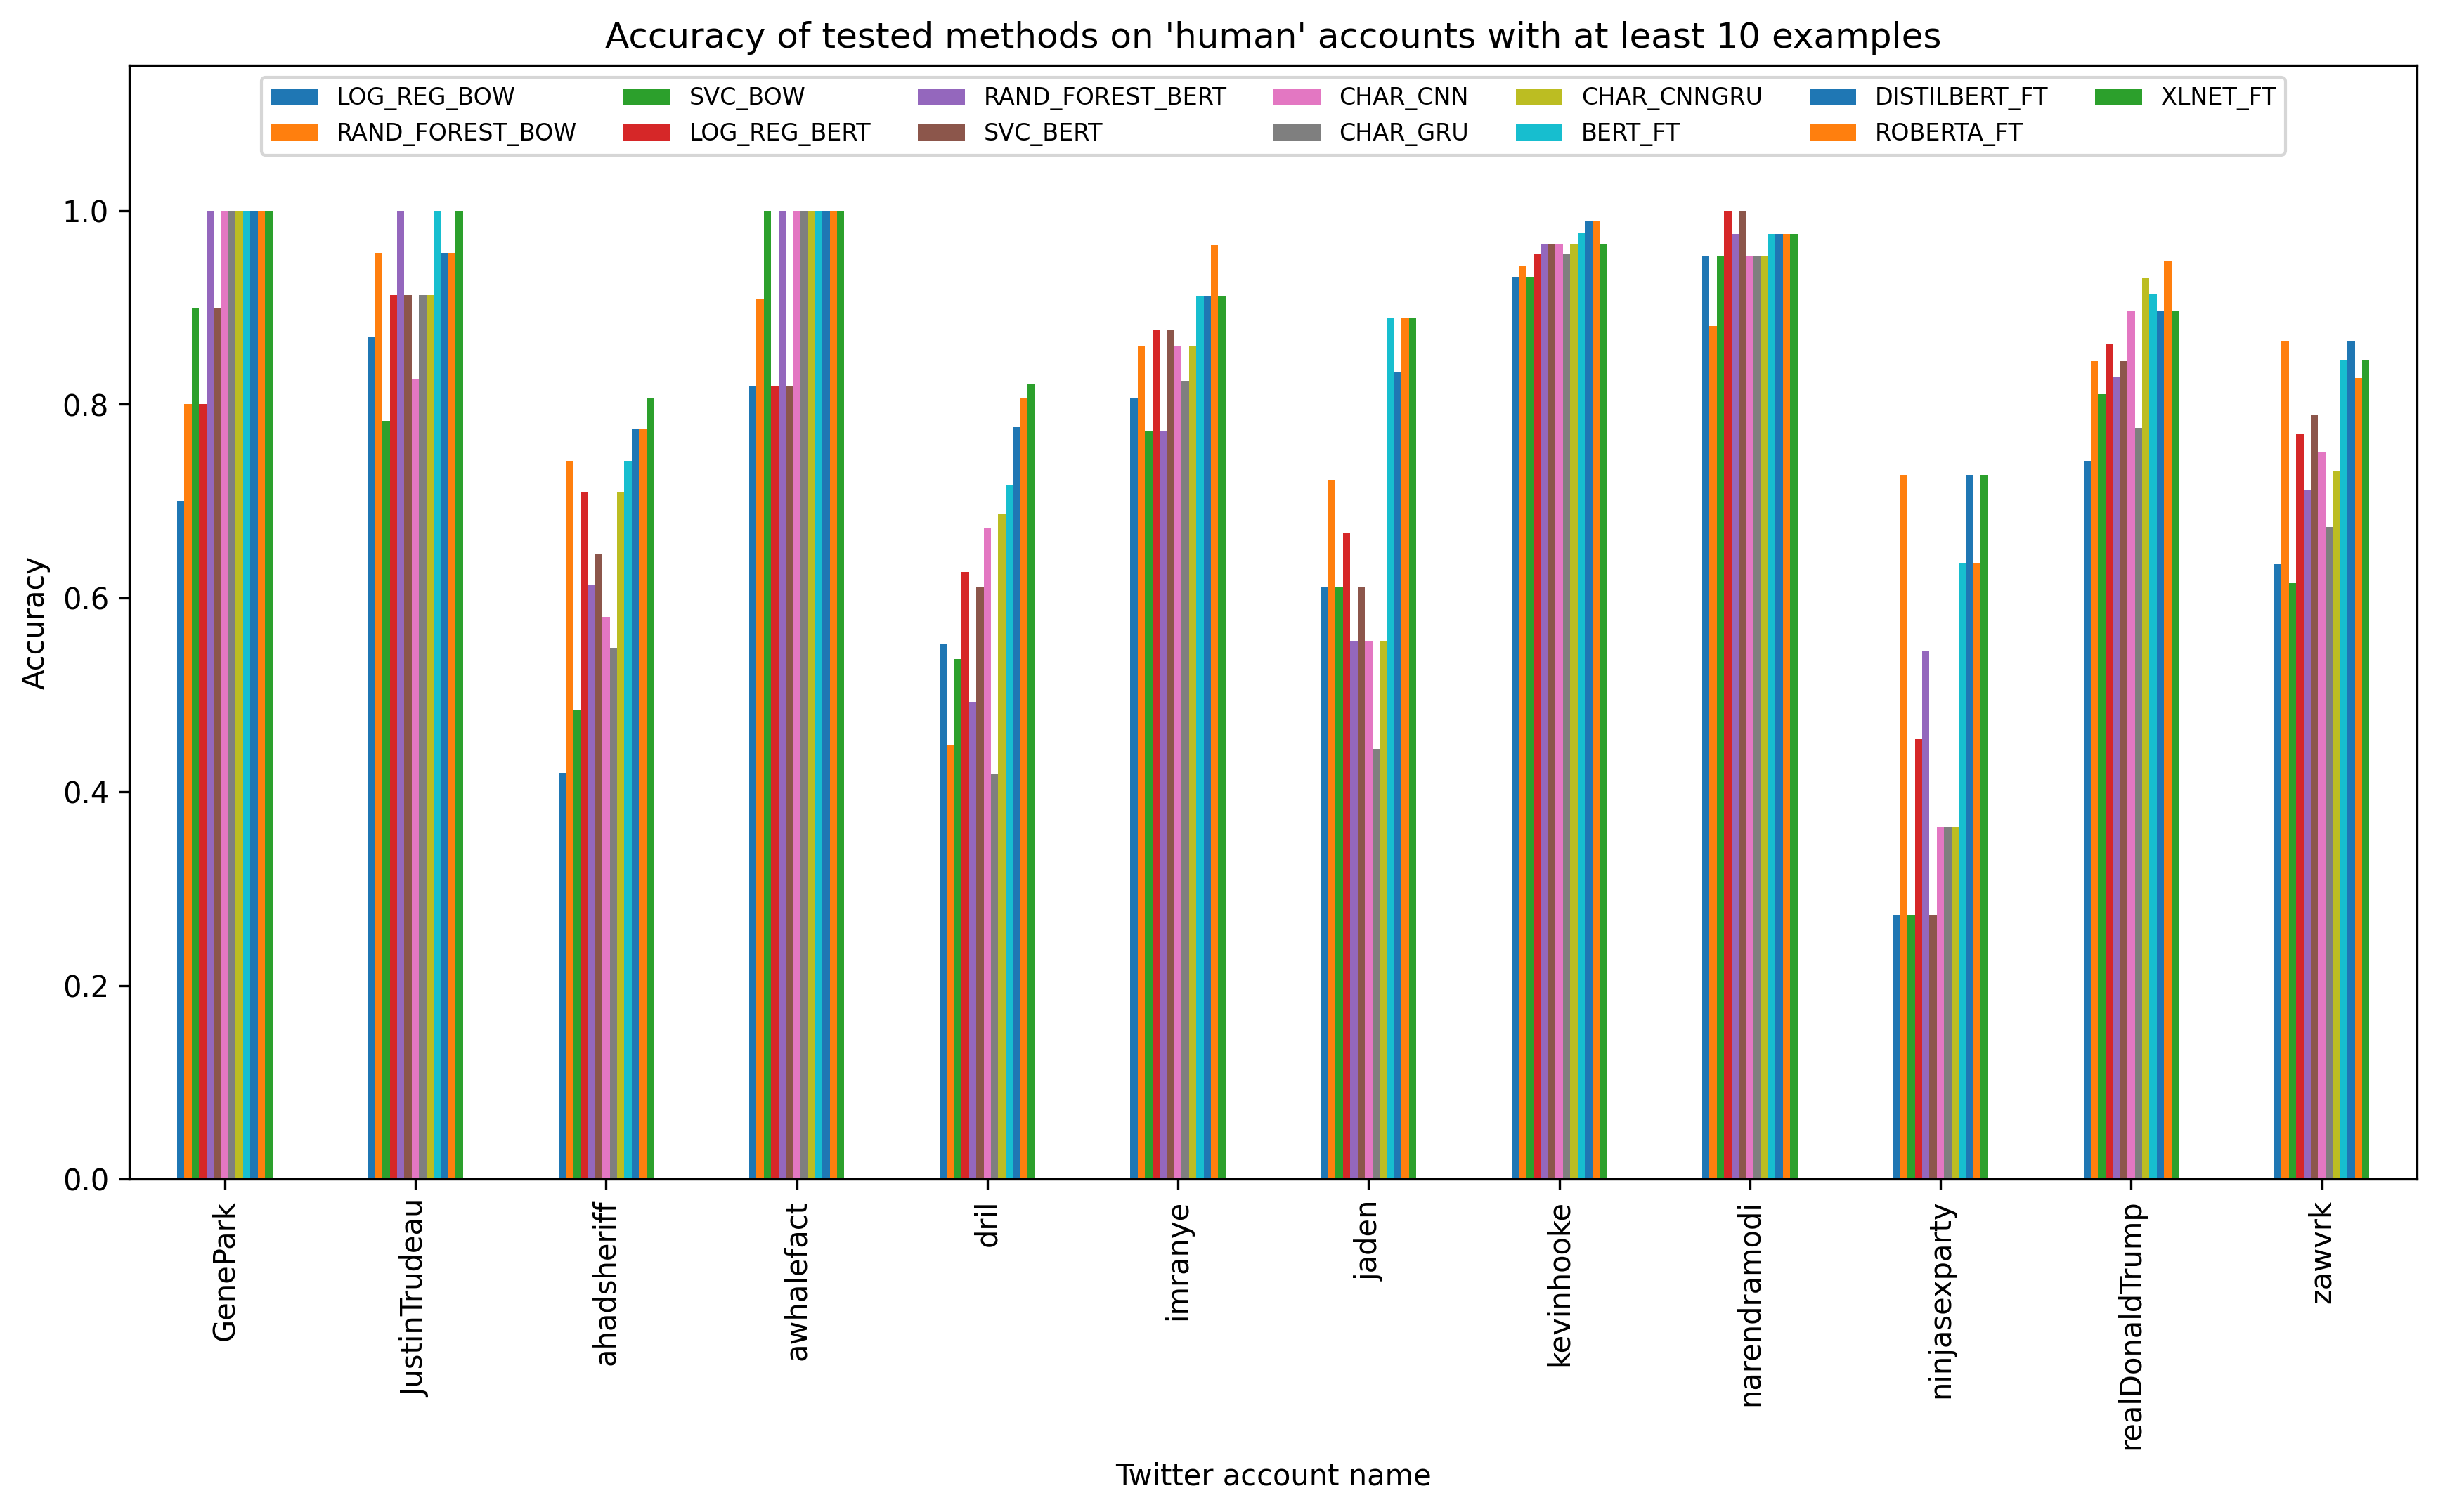

In [13]:
ax = plotErrorRatiosAllExps(dfHumans, available_result_names, 10).fillna(0).plot.bar(ylim=(0,1.15),figsize=(14,7))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=7, prop={'size': 8})
ax.set_xlabel("Twitter account name")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of tested methods on 'human' accounts with at least 10 examples")

Getting results for accounts of type "GPT2"

In [14]:
dfGPT2 = dfCmp[dfCmp["class_type"] == "gpt2"]
dfGPT2

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
11,dril_gpt2,"there is a ""war on cows"" going on right now, b...",bot,gpt2,bot,human,bot,bot,bot,bot,bot,bot,human,bot,bot,bot,bot
21,GenePark_GPT2,This is one of those tweets that will make you...,bot,gpt2,bot,bot,bot,human,bot,human,bot,bot,bot,bot,bot,bot,bot
29,dril_gpt2,i love the idea of becoming popular so much th...,bot,gpt2,bot,bot,human,human,human,human,bot,bot,human,bot,bot,bot,human
54,VBoterin,I'm thinking of P = NP,bot,gpt2,human,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
55,dril_gpt2,"the ""gast-gate"" controversy has been totally i...",bot,gpt2,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,gpt2_trump,We're at record-breaking numbers -- more than ...,bot,gpt2,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2548,gpt2_trump,@suemiskiewicz @Orwelian84 @tombrennerphoto @J...,bot,gpt2,human,human,human,bot,human,bot,bot,human,bot,bot,bot,bot,bot
2549,dril_gpt2,"HMM... i see from your posts, that the major m...",bot,gpt2,bot,bot,human,human,human,human,bot,bot,human,bot,bot,human,bot
2551,dril_gpt2,"my name is now ""Oprah"" from the classic point ...",bot,gpt2,human,bot,human,bot,bot,bot,human,bot,human,bot,bot,bot,bot


In [15]:
print_classification_reports(dfGPT2, dictLabels, available_result_names, targetNames)

**** RESULTS FOR -> LOG_REG_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.758     0.862       384

    accuracy                          0.758       384
   macro avg      0.500     0.379     0.431       384
weighted avg      1.000     0.758     0.862       384

Weighted precision: 1.0
Weighted recall: 0.7578125
Weighted F1: 0.8622222222222223
**** RESULTS FOR -> RAND_FOREST_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.654     0.791       384

    accuracy                          0.654       384
   macro avg      0.500     0.327     0.395       384
weighted avg      1.000     0.654     0.791       384

Weighted precision: 1.0
Weighted recall: 0.6536458333333334
Weighted F1: 0.7905511811023622
**** RESULTS FOR -> SVC_BOW
              precision    recall  f1-score   support

       human      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, "Accuracy of tested methods on 'gpt2' accounts with at least 10 examples")

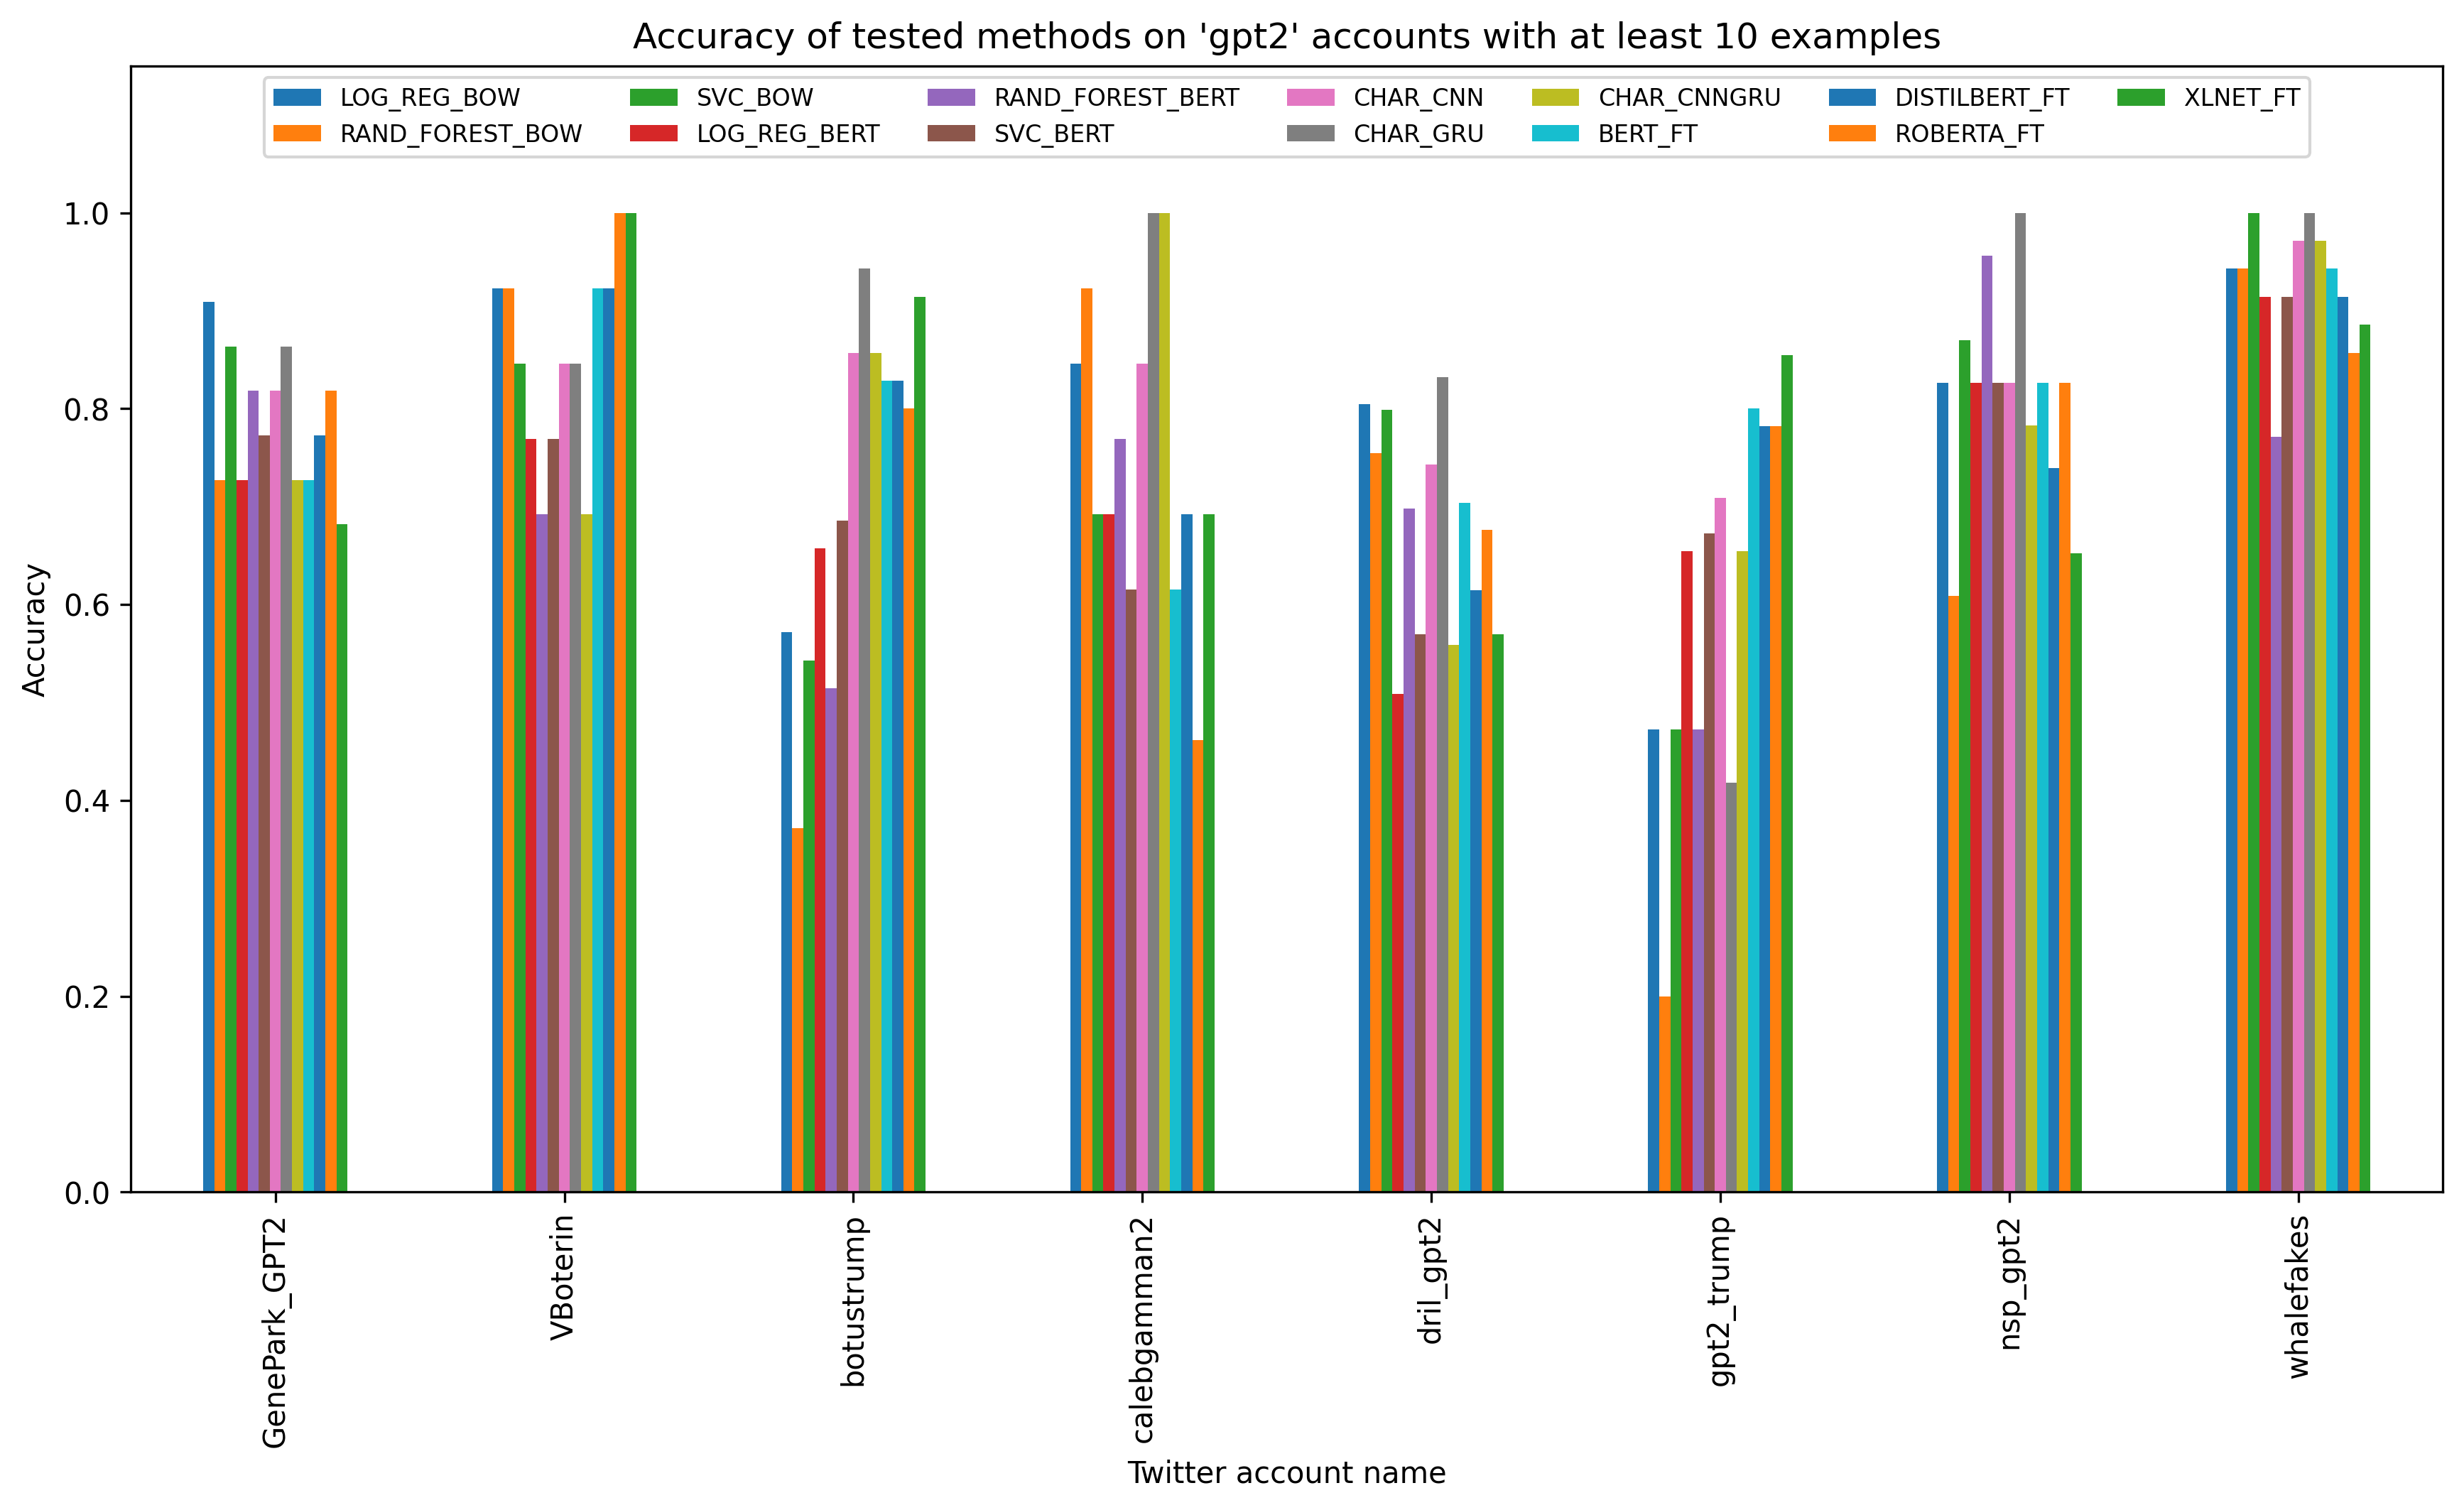

In [16]:
ax = plotErrorRatiosAllExps(dfGPT2, available_result_names, 10).fillna(0).plot.bar(ylim=(0,1.15), figsize=(14,7))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=7, prop={'size': 8})
ax.set_xlabel("Twitter account name")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of tested methods on 'gpt2' accounts with at least 10 examples")

Getting results for accounts of type "RNN"



In [17]:
dfRNN = dfCmp[dfCmp["class_type"] == "rnn"]
dfRNN

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
3,AINarendraModi,Respects on the Upt of the I good with the peo...,bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
6,DeepDrumpf,"Kansas They all said, “I don’t need anything. ...",bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
17,AINarendraModi,#ModiOpengere of the,bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
19,kevinhookebot,"""The portly and for card, and rogs of the docs...",bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
22,kevinhookebot,"""The enderstand to been was see using a some p...",bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,DrilRnn,i will NOT be a shit on here,bot,rnn,human,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,human,human
2515,AINarendraModi,What would be governance to the alliances of t...,bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2523,kevinhookebot,"""The containers a docker calls even that this ...",bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2538,kevinhookebot,"""The Java EG which for the and the market able...",bot,rnn,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot


In [18]:
print_classification_reports(dfRNN, dictLabels, available_result_names, targetNames)

**** RESULTS FOR -> LOG_REG_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.934     0.966       412

    accuracy                          0.934       412
   macro avg      0.500     0.467     0.483       412
weighted avg      1.000     0.934     0.966       412

Weighted precision: 1.0
Weighted recall: 0.9344660194174758
Weighted F1: 0.9661229611041408
**** RESULTS FOR -> RAND_FOREST_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.937     0.967       412

    accuracy                          0.937       412
   macro avg      0.500     0.468     0.484       412
weighted avg      1.000     0.937     0.967       412

Weighted precision: 1.0
Weighted recall: 0.9368932038834952
Weighted F1: 0.9674185463659148
**** RESULTS FOR -> SVC_BOW
              precision    recall  f1-score   support

       huma

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, "Accuracy of tested methods on 'rnn' accounts with at least 5 examples")

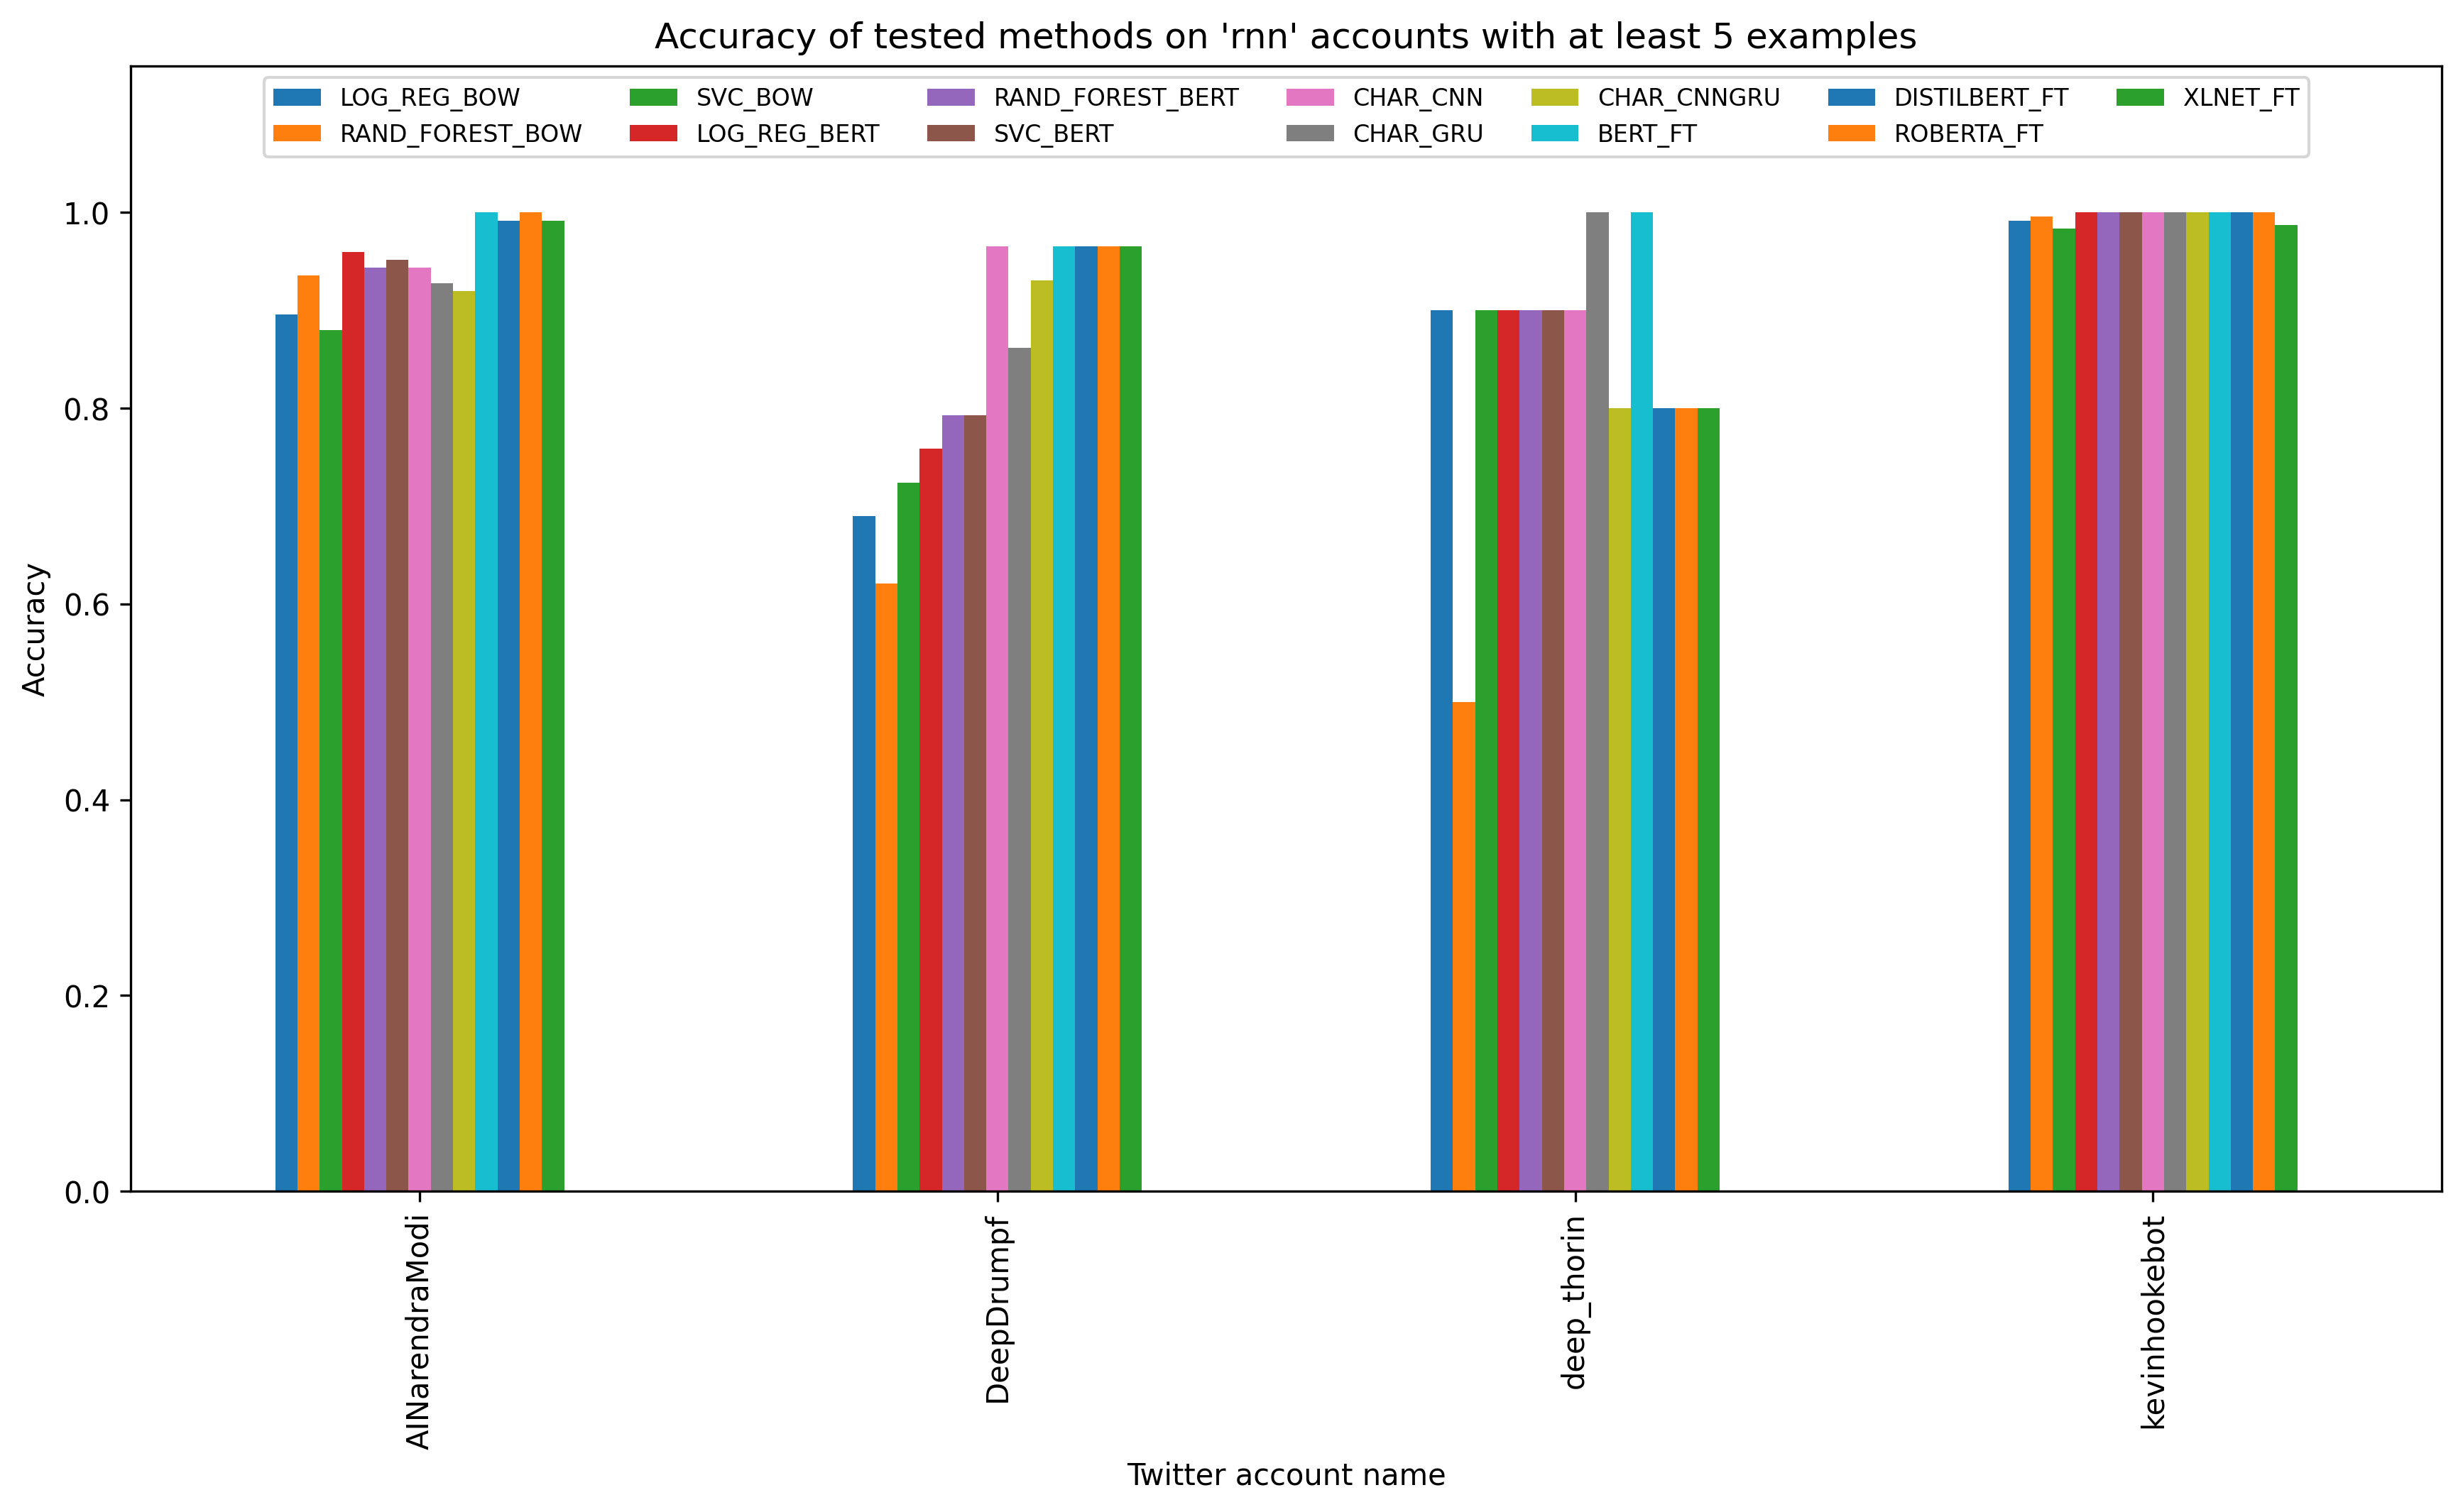

In [19]:
ax = plotErrorRatiosAllExps(dfRNN, available_result_names, 5).fillna(0).plot.bar(ylim=(0,1.15), figsize=(14,7))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=7, prop={'size': 8})
ax.set_xlabel("Twitter account name")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of tested methods on 'rnn' accounts with at least 5 examples")

Getting results for accounts of type "Others"

In [20]:
dfOthers = dfCmp[dfCmp["class_type"] == "others"]
dfOthers

,screen_name,text,gold,class_type,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
5,imranyebot,Fifty Four Degrees sent it was,bot,others,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
13,zawarbot,yo this fall weather is poison and socially pr...,bot,others,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,human
25,zawarbot,1 week in silence than assault rifles?,bot,others,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
27,imranyebot,remember the same,bot,others,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
28,zawarbot,ill spread your own adventure withdrawls <U+00...,bot,others,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536,theJadenTrudeau,and I announce The Irish Taoiseach Is Amazing,bot,others,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2539,zawarbot,i show my tweets and chief keef,bot,others,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2541,imranyebot,LMFAOOOO U right now vs a dollar store subhi t...,bot,others,bot,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot
2542,imranyebot,thinking they give me,bot,others,human,human,human,bot,bot,bot,bot,bot,bot,bot,bot,bot,bot


In [21]:
print_classification_reports(dfOthers, dictLabels, available_result_names, targetNames)

**** RESULTS FOR -> LOG_REG_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.874     0.933       484

    accuracy                          0.874       484
   macro avg      0.500     0.437     0.466       484
weighted avg      1.000     0.874     0.933       484

Weighted precision: 1.0
Weighted recall: 0.8739669421487604
Weighted F1: 0.9327453142227122
**** RESULTS FOR -> RAND_FOREST_BOW
              precision    recall  f1-score   support

       human      0.000     0.000     0.000         0
         bot      1.000     0.659     0.795       484

    accuracy                          0.659       484
   macro avg      0.500     0.330     0.397       484
weighted avg      1.000     0.659     0.795       484

Weighted precision: 1.0
Weighted recall: 0.6590909090909091
Weighted F1: 0.7945205479452054
**** RESULTS FOR -> SVC_BOW
              precision    recall  f1-score   support

       huma

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, "Accuracy of tested methods on 'others' accounts with at least 5 examples")

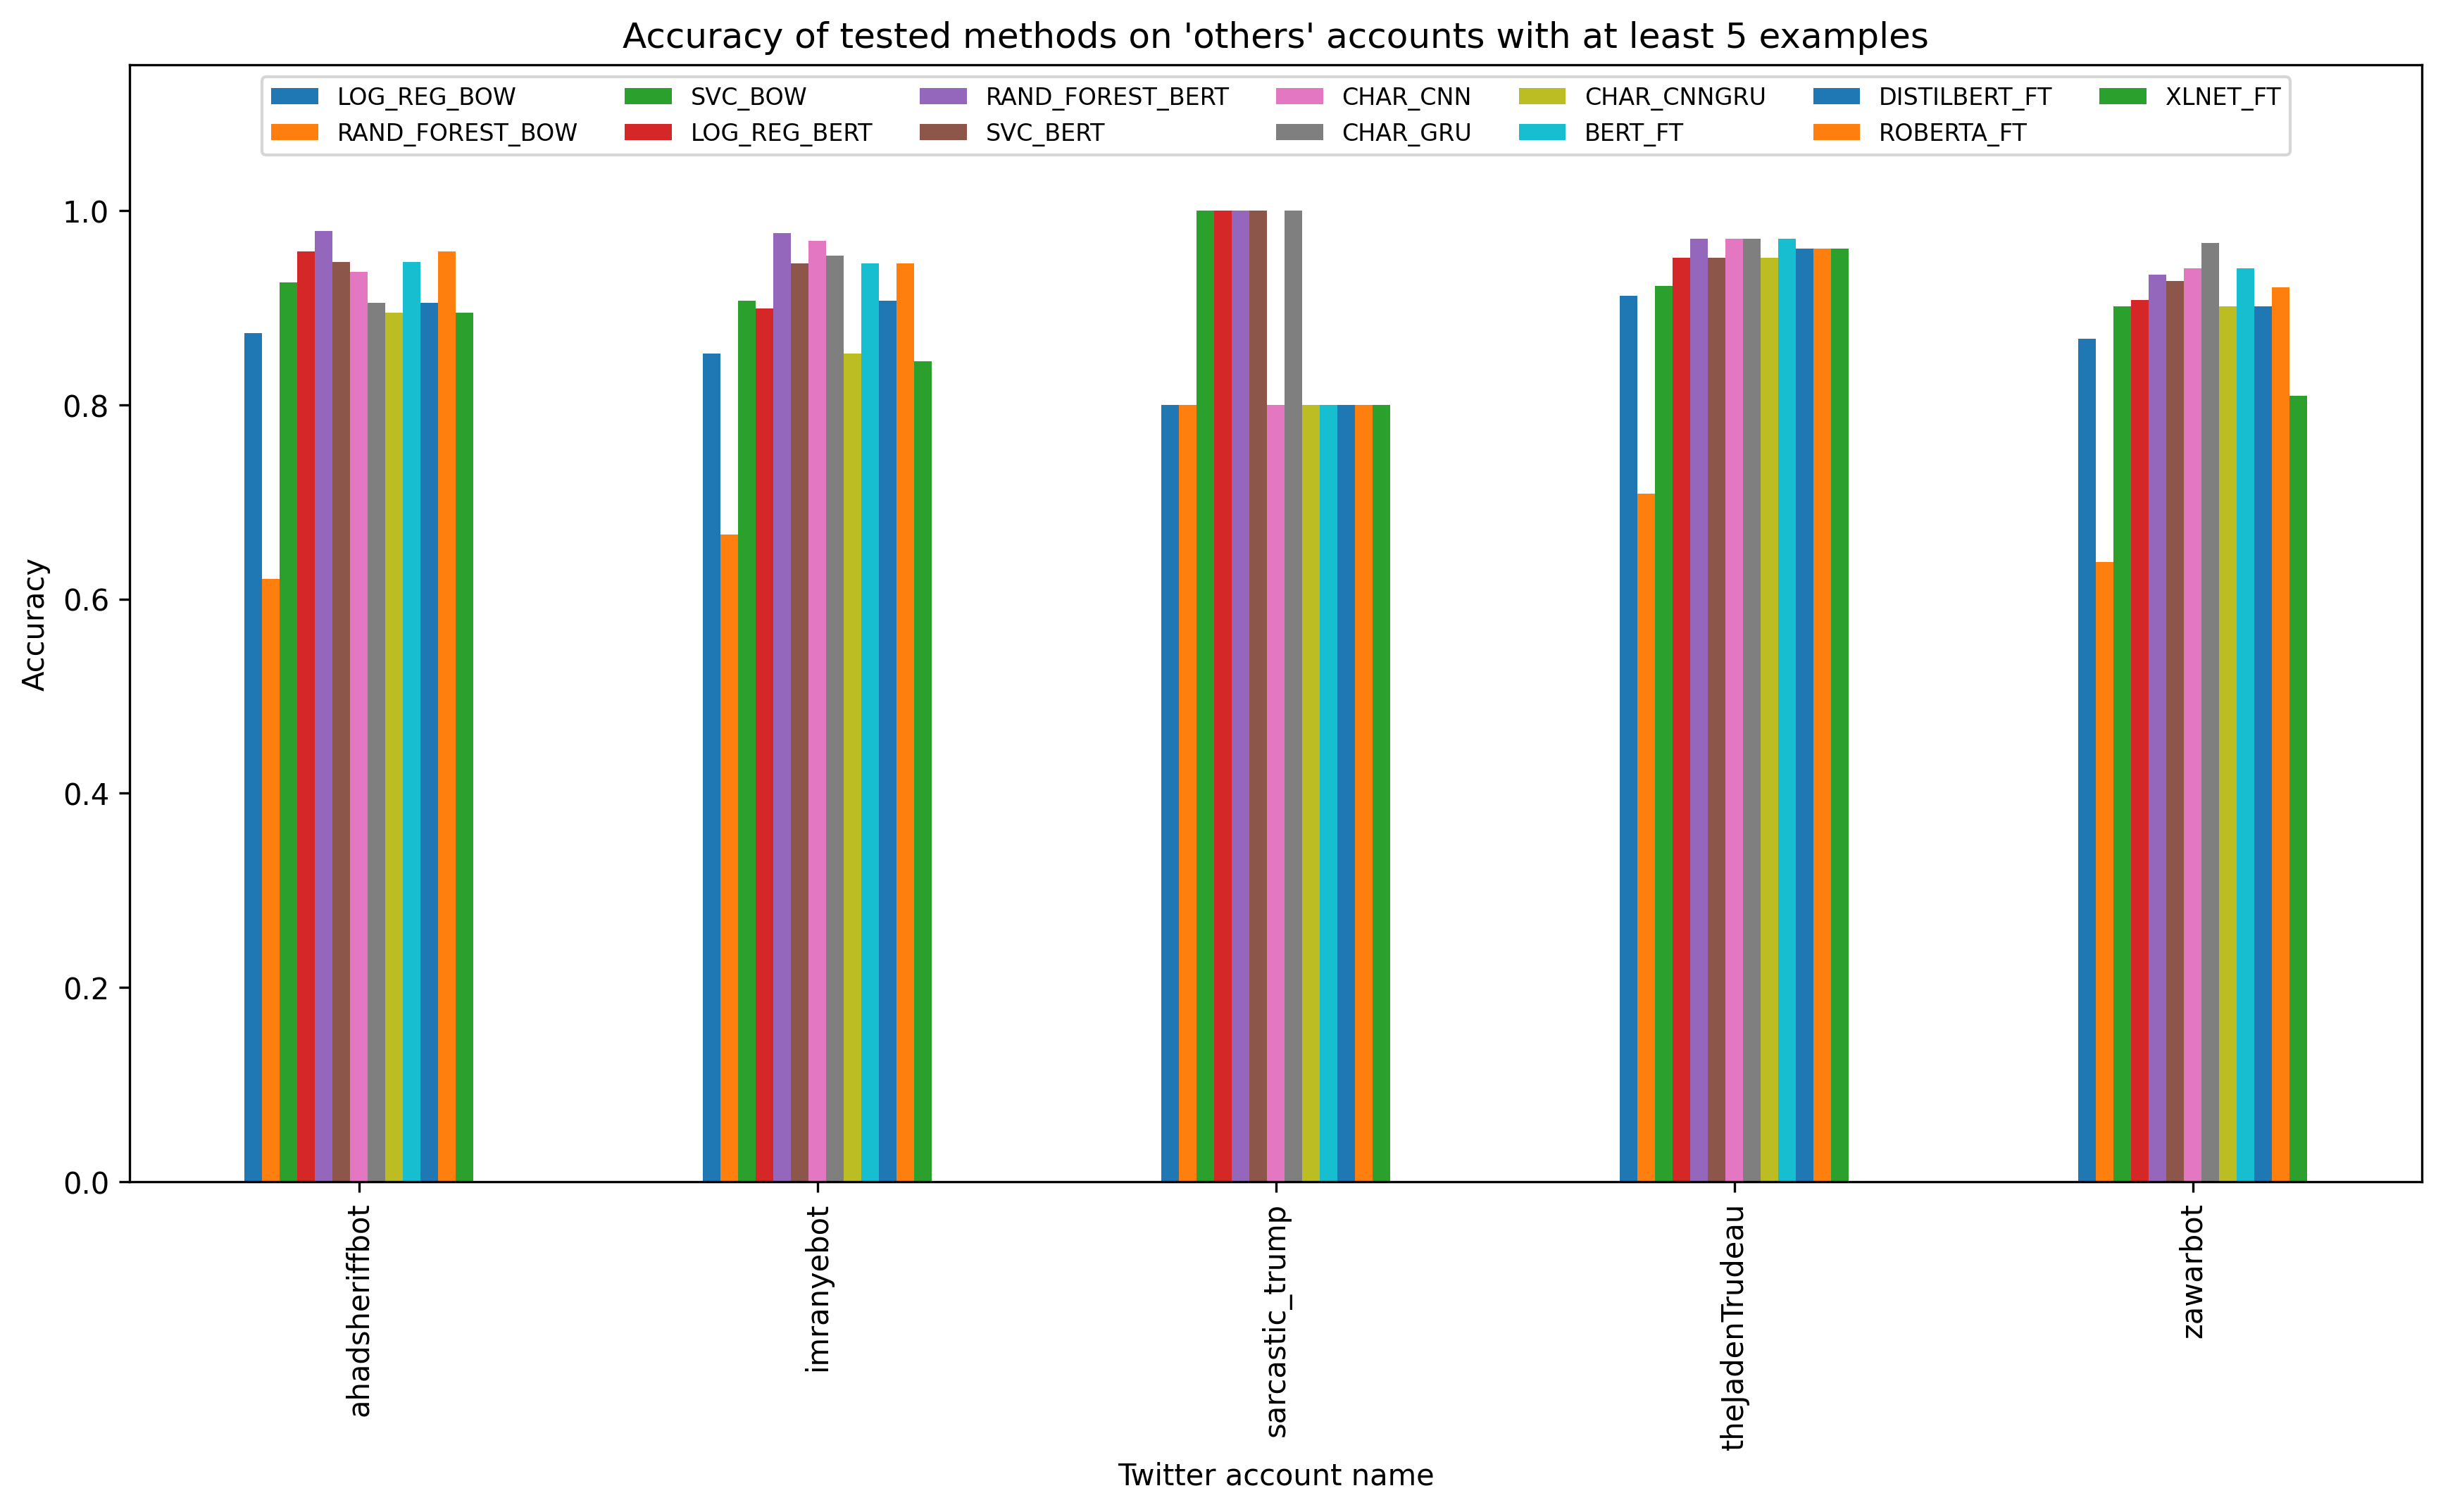

In [22]:
ax = plotErrorRatiosAllExps(dfOthers, available_result_names, 5).fillna(0).plot.bar(ylim=(0,1.15), figsize=(14,7))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=7, prop={'size': 8})
ax.set_xlabel("Twitter account name")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of tested methods on 'others' accounts with at least 5 examples")

In [23]:
# See example at https://stackoverflow.com/questions/12286607/making-heatmap-from-pandas-dataframe
def buildAccuracyDFBasedOnClassTypes(df, available_result_names):
  from sklearn.metrics import accuracy_score
  import pandas as pd

  classTypes = ["global", "human", "gpt2", "rnn", "others"]
  names = [v for k,v in mapMethodNames.items()]
  print(names)
  ctAccuracies = []
  for ct in classTypes:
    if ct == "global":
      dfTmp = df
    elif ct == "human":
      dfTmp = df[df["class_type"]==ct].sample(frac=0.5, replace=False, random_state=1)
    else:
      dfTmp = df[df["class_type"]==ct]
    accuracies = []
    for config in names:
      gold = dfTmp["gold"]
      prediction = dfTmp[config]
      acc = accuracy_score(gold, prediction)
      accuracies.append(acc)
    ctAccuracies.append(accuracies)

  names = list(names)
  dfTarget = pd.DataFrame(ctAccuracies, index=classTypes, columns=names)
  return dfTarget


dfAcc = buildAccuracyDFBasedOnClassTypes(dfCmp, available_result_names)

['LOG_REG_BOW', 'RAND_FOREST_BOW', 'SVC_BOW', 'LOG_REG_BERT', 'RAND_FOREST_BERT', 'SVC_BERT', 'CHAR_CNN', 'CHAR_GRU', 'CHAR_CNNGRU', 'BERT_FT', 'DISTILBERT_FT', 'ROBERTA_FT', 'XLNET_FT']


In [24]:
dfAcc

,LOG_REG_BOW,RAND_FOREST_BOW,SVC_BOW,LOG_REG_BERT,RAND_FOREST_BERT,SVC_BERT,CHAR_CNN,CHAR_GRU,CHAR_CNNGRU,BERT_FT,DISTILBERT_FT,ROBERTA_FT,XLNET_FT
global,0.803753,0.772478,0.811181,0.835418,0.827209,0.842455,0.851056,0.829945,0.836591,0.896403,0.885848,0.904613,0.876466
human,0.740219,0.807512,0.746479,0.816901,0.779343,0.812207,0.804382,0.751174,0.832551,0.877934,0.890454,0.902973,0.899844
gpt2,0.757812,0.653646,0.750000,0.632812,0.679688,0.666667,0.781250,0.817708,0.679688,0.768229,0.718750,0.742188,0.708333
rnn,0.934466,0.936893,0.927184,0.966019,0.963592,0.966019,0.973301,0.966019,0.963592,0.997573,0.990291,0.987864,0.978155
others,0.873967,0.659091,0.913223,0.925620,0.962810,0.942149,0.952479,0.952479,0.896694,0.948347,0.915289,0.942149,0.867769


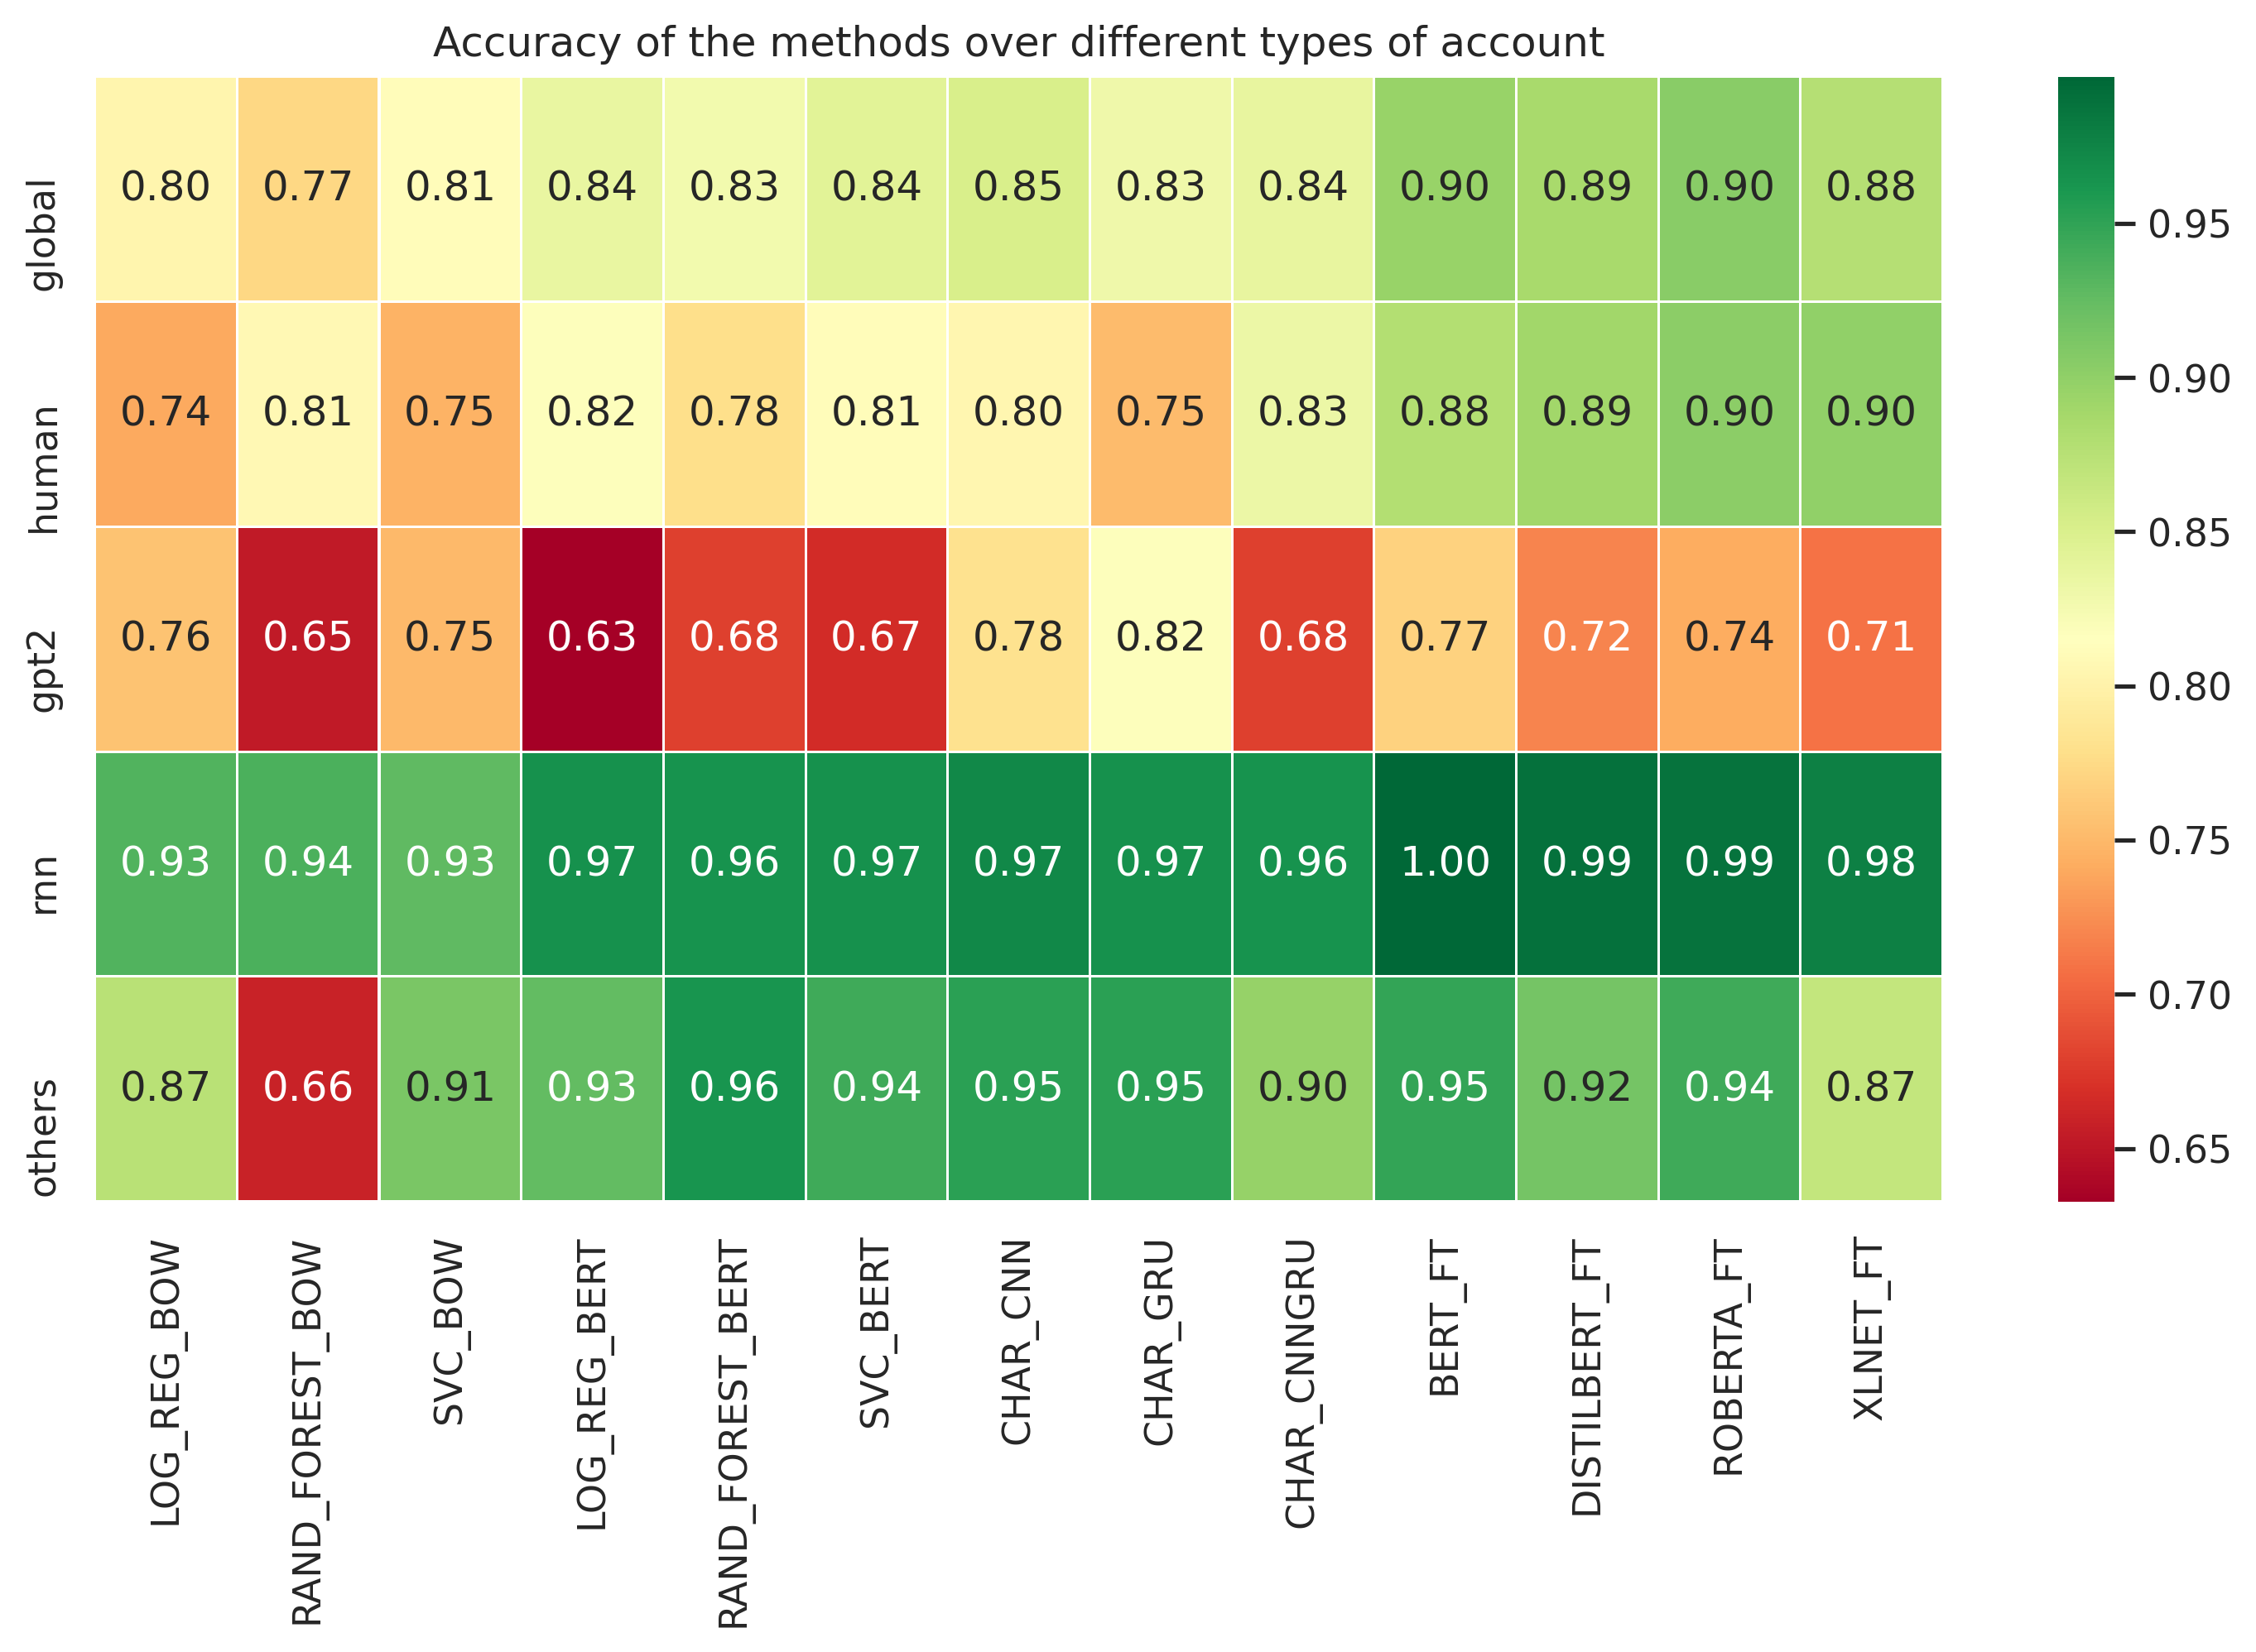

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
# _r reverses the normal order of the color map 'RdYlGn'
plt.figure(figsize = (12,6))
plt.title("Accuracy of the methods over different types of account")
sns.set(font_scale=1)
sns.heatmap(dfAcc, cmap='RdYlGn', linewidths=0.5, annot=True, fmt='.2f')

Text(0.5, 1.0, "Accuracy of tested methods on 'human' accounts with at least 10 examples")

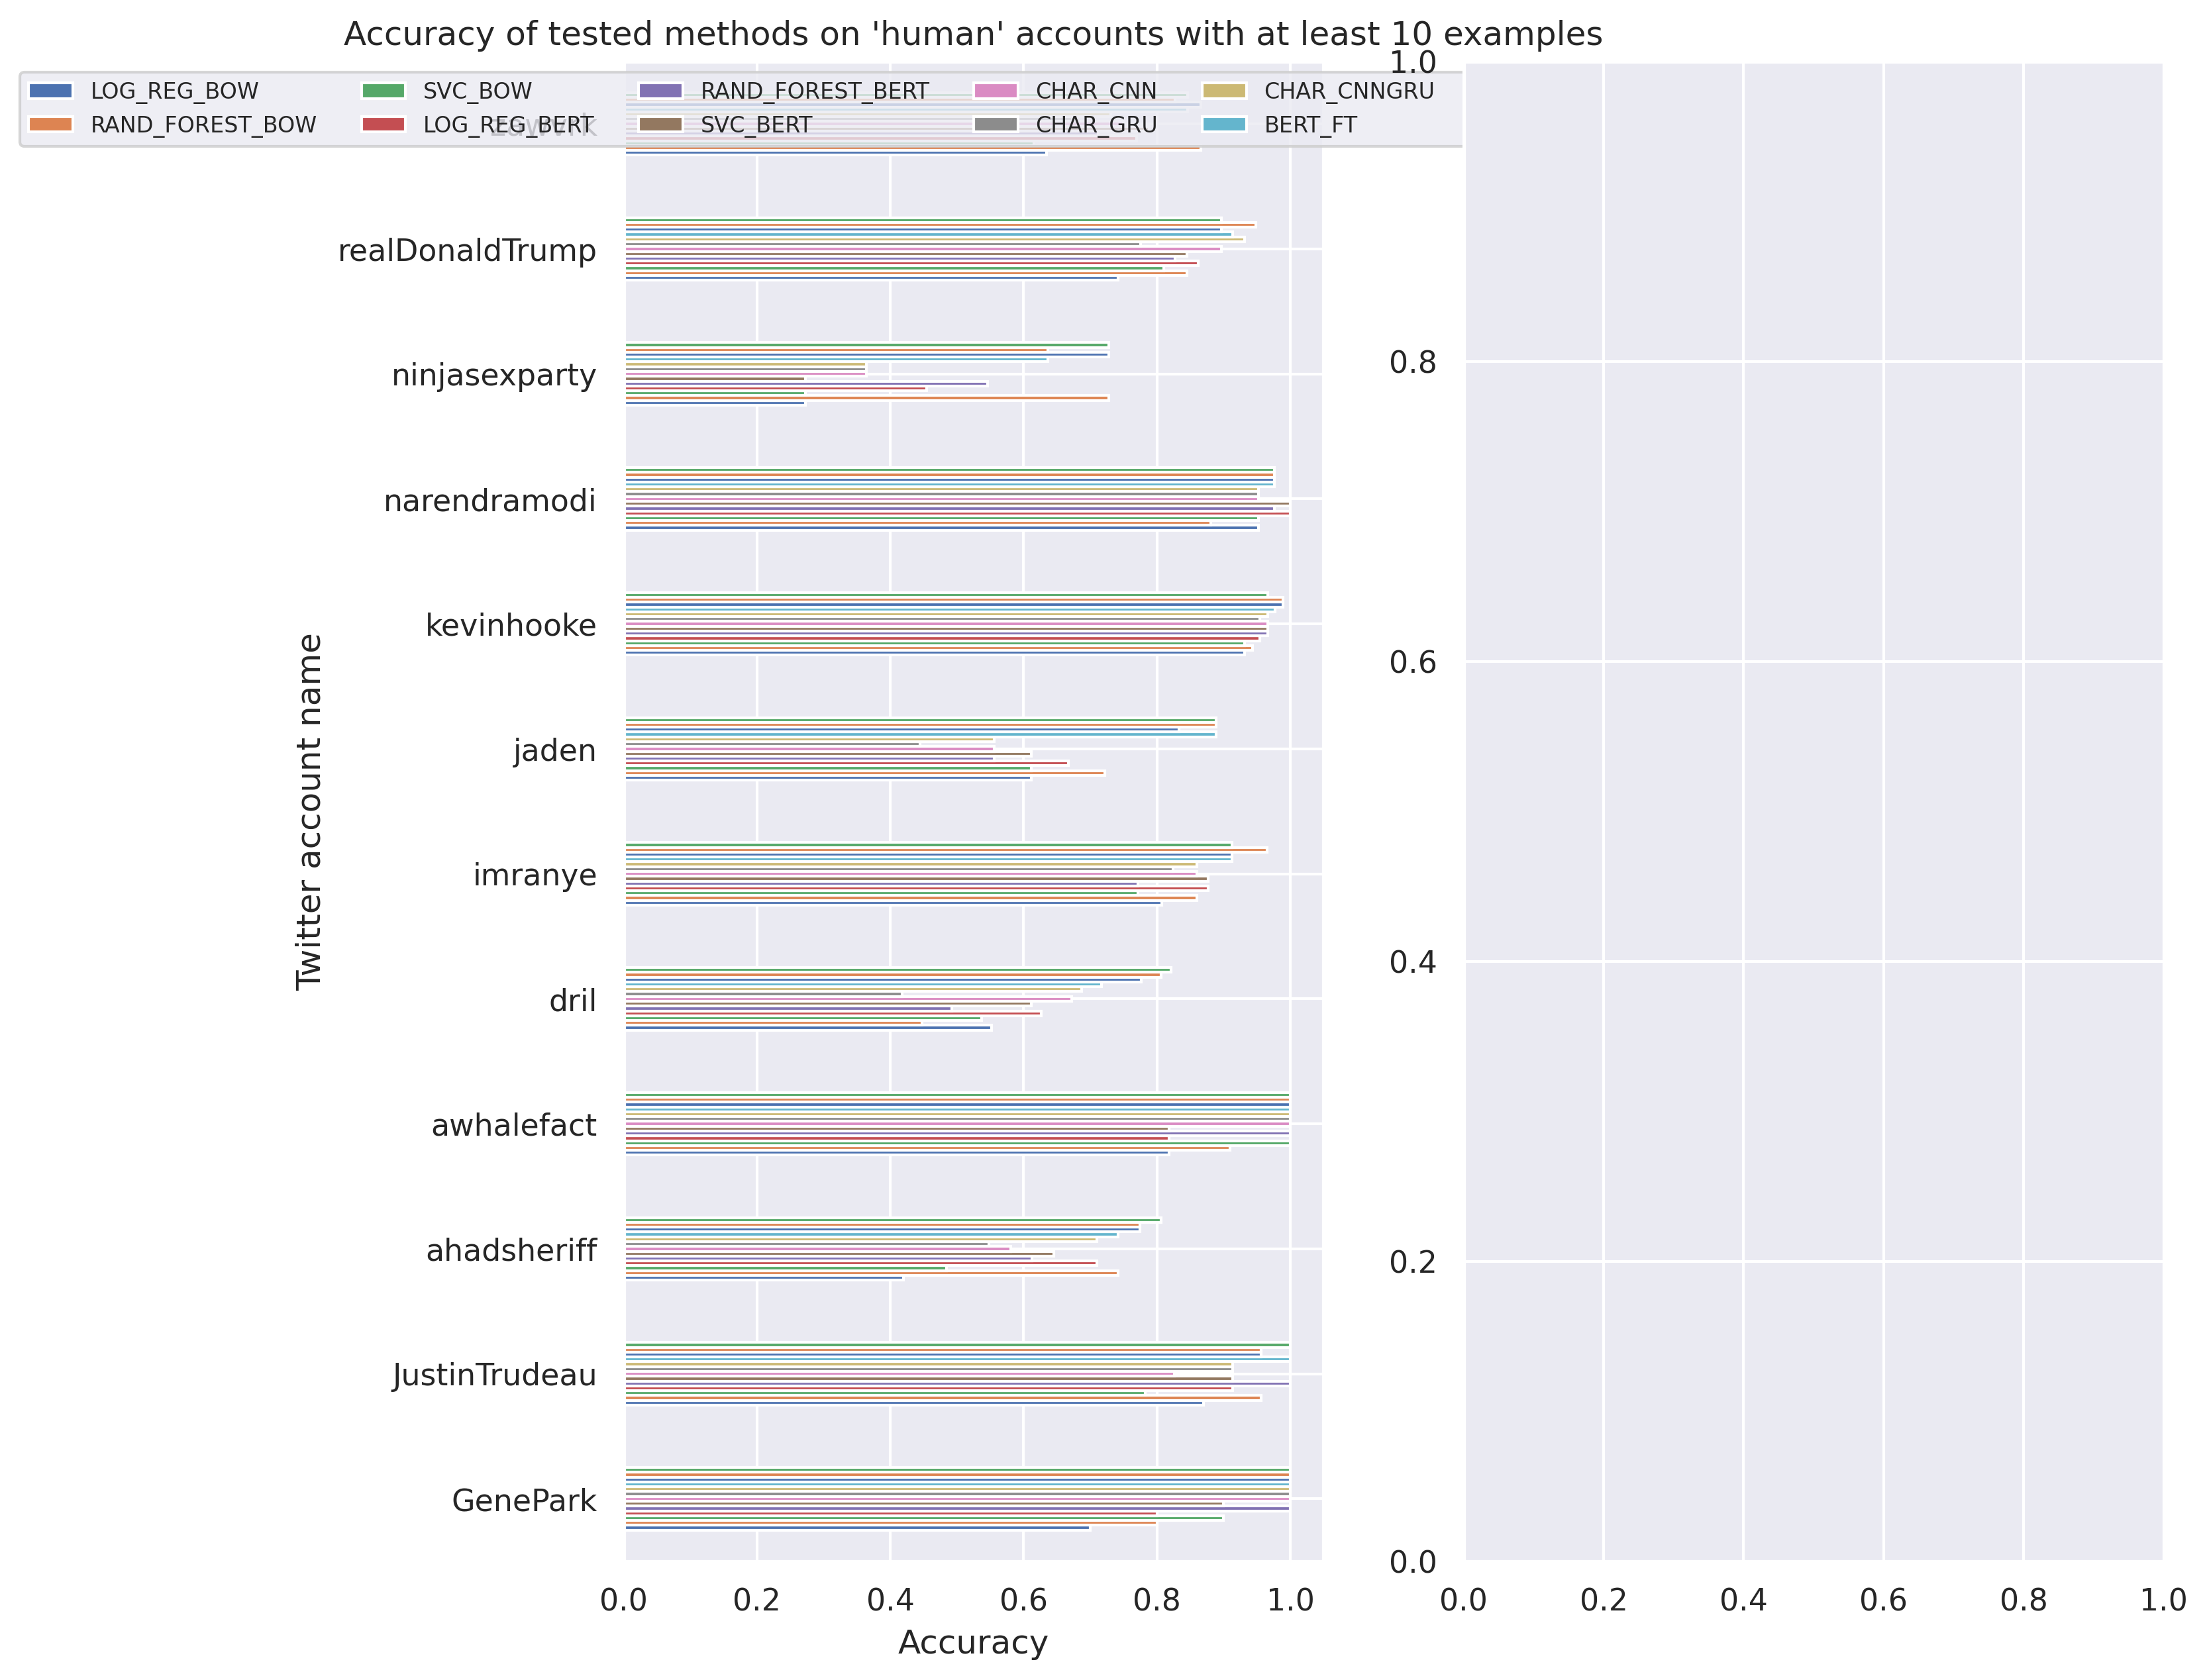

In [26]:
import matplotlib.pyplot as plt

#plt.figure(figsize = (10,5))
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10,10)

ax_0 = plotErrorRatiosAllExps(dfHumans, available_result_names, 10).fillna(0).plot.barh(ax=axes[0], ylim=(0,1.05))
#ax_0 = plotErrorRatiosAllExps(dfHumans, available_result_names, 10).fillna(0).plot.bar()

ax_0.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=7, prop={'size': 8})
ax_0.set_ylabel("Twitter account name")
ax_0.set_xlabel("Accuracy")
ax_0.set_title("Accuracy of tested methods on 'human' accounts with at least 10 examples")



